In [0]:
import xgboost
import pandas as pd
from xgboost import DMatrix, train
import numpy as np
import sys, pickle
from copy import deepcopy
from sklearn.metrics import ndcg_score
import os
import matplotlib.pyplot as plt

DATA_DIR = '/content/' # Google Colab data folder. You could replace with your data folder if needed

# Train and Cross-validate paraphrase ranking models

In [18]:
# Upload all datasets to Google colab if needed
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('You uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving cross_validation_dataset.pkl to cross_validation_dataset.pkl
Saving parabank-eval-all.pkl to parabank-eval-all.pkl
Saving stsbenchmarks-all.pkl to stsbenchmarks-all.pkl
You uploaded file "cross_validation_dataset.pkl" with length 2282748 bytes
You uploaded file "parabank-eval-all.pkl" with length 2224202 bytes
You uploaded file "stsbenchmarks-all.pkl" with length 7496781 bytes


In [19]:
# Load data
with open(os.path.join(DATA_DIR, 'cross_validation_dataset.pkl'), 'rb') as f:
    data = pickle.load(f)
DOC_IDS = list(data.keys())
print(DOC_IDS)

['eep00767', 'eep00978', 'eep00349', 'eep00996', 'eep00979']


In [20]:
# Feature Names
features = list(data['eep00767'][0]['features_wrt_each_paraphrase'].columns)
print('Feature Names:\n', features)
f_name = {"f{}".format(i):features[i] for i in range(0, len(features))}
print('Feature Dictionary:\n', f_name)

Feature Names:
 ['cosine_similarity', 'tree_edit', 'seq_edit_word', 'seq_edit_char', 'blue-1', 'blue-2', 'blue-3', 'blue-4', 'rouge-1', 'rouge-2', 'rouge-3', 'rouge-4', 'rouge-l', 'rouge-w']
Feature Dictionary:
 {'f0': 'cosine_similarity', 'f1': 'tree_edit', 'f2': 'seq_edit_word', 'f3': 'seq_edit_char', 'f4': 'blue-1', 'f5': 'blue-2', 'f6': 'blue-3', 'f7': 'blue-4', 'f8': 'rouge-1', 'f9': 'rouge-2', 'f10': 'rouge-3', 'f11': 'rouge-4', 'f12': 'rouge-l', 'f13': 'rouge-w'}


In [0]:
# Label pre-processing

def indexRanks(scores):
    """
    Give back ranking of a list of scalars. Ranking is given by index.
    :param scores: list-like of scalar numbers
    :return: ranking by index
    """
    sorted_indices = np.argsort(100 - np.array(scores))  # decremental sorting
    ranks = [None] * len(scores)
    for idx in range(len(scores)):
        ranks[sorted_indices[idx]] = idx
    return ranks

def rank(scores, mode):
    """
    Return ranking of a list of scalars, under a specific mode.
    :param scores: list-like of scalar numbers
    :param mode: "raw", "index"
    :return:
    """
    if mode == "Raw":
        return list(scores)
    elif mode == "Index":
        return indexRanks(scores)
    else:
        raise ValueError("Unable to recognize ranking mode.")

ranking_mode = ["Raw", "Index"]

In [22]:
# Split train / test

ndcg_scores = []
for SCALAR_RANK_MODE in ranking_mode:
  cross_score = []
  weight = []
  for fold_idx in range(len(DOC_IDS)):
      valid_split = [DOC_IDS[fold_idx]]
      train_split = deepcopy(DOC_IDS)
      train_split.pop(fold_idx)

      y_train = []
      x_train = []
      group_train = []

      for doc_id in train_split:
          for sent in data[doc_id]:
              for rankings in sent['human_ranking_of_paraphrases'].values():
                  x_train += sent['features_wrt_each_paraphrase'].to_numpy().tolist()
                  y_train += rank(rankings, SCALAR_RANK_MODE)
                  group_train.append(len(rankings))

      y_valid = []
      x_valid = []
      group_valid = []
      for doc_id in valid_split:
          for sent in data[doc_id]:
              y_temp = []
              for rankings in sent['human_ranking_of_paraphrases'].values():
                  x_valid += sent['features_wrt_each_paraphrase'].to_numpy().tolist()
                  y_valid += rank(rankings, SCALAR_RANK_MODE)
                  group_valid.append(len(rankings))

      x_train = np.array(x_train)
      y_train = np.array(y_train)
      group_train = np.array(group_train)

      x_valid = np.array(x_valid)
      y_valid = np.array(y_valid)
      group_valid = np.array(group_valid)

      # Train ranking model
      params = {'objective': 'rank:map', 'learning_rate': 0.1, 'gamma': 1.0, 'min_child_weight': 0.1, 'max_depth': 6, 'n_estimators': 4,
                'eval_metric': 'ndcg@10'}
      model = xgboost.sklearn.XGBRanker(**params)
      model.fit(x_train, y_train, group_train, verbose=False,
                eval_set=[(x_valid, y_valid)], eval_group=[group_valid])

      # Evaluate ranking model
      pred = model.predict(x_valid)
      pred = np.reshape(pred, (-1, 10))
      evalLabel = np.reshape(y_valid, (-1, 10))
      cross_score.append(ndcg_score(evalLabel, pred, 10))
      weight.append(len(pred))

  # Cross-validation score in total
  print("Mode: ", SCALAR_RANK_MODE) 
  ndcg = np.sum([s * w for s, w in zip(cross_score, weight)])/np.sum(weight)
  ndcg_scores.append(ndcg)
  print("NDCG@10=%f" % ndcg)

Mode:  Raw
NDCG@10=0.915350
Mode:  Index
NDCG@10=0.810574


# Prepare to benchmark: Re-train paraphrase ranking models with all data

In [0]:
# Final Training
models = {}
dataset ={}
for SCALAR_RANK_MODE in ranking_mode:
      y_train = []
      x_train = []
      group_train = []
      for doc_id in DOC_IDS:
          for sent in data[doc_id]:
              for rankings in sent['human_ranking_of_paraphrases'].values():
                  x_train += sent['features_wrt_each_paraphrase'].to_numpy().tolist()
                  y_train += rank(rankings, SCALAR_RANK_MODE)
                  group_train.append(len(rankings))

      x_train = np.array(x_train)
      y_train = np.array(y_train)
      group_train = np.array(group_train)

     # Train ranking models with all data
      params = {'objective': 'rank:map', 'learning_rate': 0.1, 'gamma': 1.0, 'min_child_weight': 0.1, 'max_depth': 6, 'n_estimators': 10,
                'eval_metric': 'ndcg@10'}
      model = xgboost.sklearn.XGBRanker(**params)
      model.fit(x_train, y_train, group_train, verbose=False)
      models[SCALAR_RANK_MODE] = model
      dataset[SCALAR_RANK_MODE]=[x_train, y_train]

## Feature importance

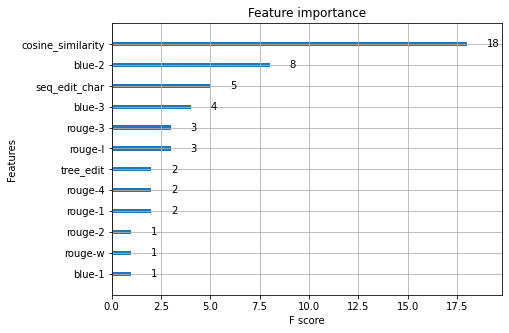

In [25]:
mode = "Raw"
# Feature Importance
xgboost.plot_importance(models[mode])
plt.rcParams['figure.figsize'] = [7, 5]
locs, labels = plt.yticks()
names = [f_name[labels[i].get_text()] for i in locs]
plt.yticks(locs, names)
plt.show()

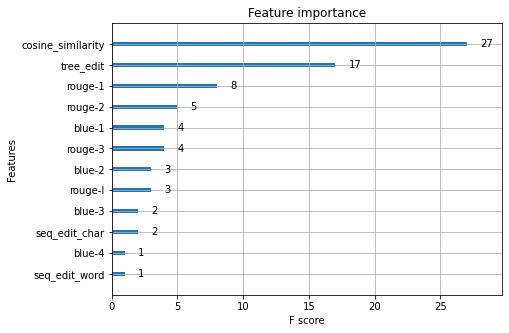

In [27]:
mode = "Index"
# Feature Importance
xgboost.plot_importance(models[mode])
plt.rcParams['figure.figsize'] = [7, 5]
locs, labels = plt.yticks()
names = [f_name[labels[i].get_text()] for i in locs]
plt.yticks(locs, names)
plt.show()

# Test on benchmarking datasets

## STS Benchmark

In [28]:
with open(os.path.join(DATA_DIR,'stsbenchmarks-all.pkl'), 'rb') as f:
    stsdata = pickle.load(f)
STS_IDS = list(stsdata.keys())
print(STS_IDS)

['dev', 'test', 'train']


In [0]:
# Create testing data and a dataframe
columns=['Genre', 'File', 'Year', 'ID', 'Reference', 'Paraphrase', 'Ranking']
df = pd.DataFrame(columns=columns)
x_test = []
i = 0
for doc_id in STS_IDS:
  for sent in stsdata[doc_id]:
    x_test += sent['features_wrt_each_paraphrase'].to_numpy().tolist()
    ranking = sent['human_ranking_of_paraphrase']['human1']
    row = [sent['Genre'], sent['File'], sent['Year'], sent['ID'], sent['Reference'], sent['Paraphrase'][0], ranking]
    df = df.append(pd.Series(row, index=columns), ignore_index=True)    
x_test = np.array(x_test)

In [0]:
# Evaluation
for mode in ranking_mode:
    y_pred = 5*models[mode].predict(x_test)
    num = len(y_pred) - len(y_pred)%10
    print("Number of scoring samples:", num)
    # Add predicted score to the dataframe report
    df[mode] = pd.Series(y_pred).values

Number of scoring samples: 8620
Number of scoring samples: 8620


In [0]:
# Export sorted CSVs

# By human semantic similarity ranking
df2 = df.sort_values(by=['Ranking'],ascending=False)
df2.to_csv(os.path.join(DATA_DIR,"STS_by_HumanRanking.csv"), index=True)

# By Raw model
df2 = df.copy()
df2['F1'] = (2*df2['Raw']*df2['Ranking'])/(df2['Raw']+df2['Ranking'])
df2 = df2.sort_values(by=['F1'],ascending=False)
df2.to_csv(os.path.join(DATA_DIR,"STS_by_RawModel.csv"), index=True)

# By Index model
df2 = df.copy()
df2['F1'] = (2*df2['Index']*df2['Ranking'])/(df2['Index']+df2['Ranking'])
df2 = df2.sort_values(by=['F1'],ascending=False)
df2.to_csv(os.path.join(DATA_DIR,"STS_by_IndexModel.csv"), index=True)

## ParaBank Evaluation

In [0]:
"""# Test on parabank-eval dataset

## Load parabank-eval dataset
"""

# !pip install google-colab
# Upload data to Google colab
from google.colab import files

# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('You uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

with open(os.path.join(DATA_DIR,'parabank-eval-all.pkl'), 'rb') as f:
    pbdata = pickle.load(f)
PB_IDS = list(pbdata.keys())
print(PB_IDS)

['parabank']


In [0]:
# Read ParaBank evaluation corpus
from statistics import mean
# Create testing data and a dataframe
columns=['Ref_ID', 'Reference', 'Paraphrase', 'HumanScore', 'GM']
df = pd.DataFrame(columns=columns)
x_test = []
ref_id = -1
for doc_id in PB_IDS:
  for sent in pbdata[doc_id]:
    ref_id+=1 
    ref = sent['Reference']
    paras = sent['Paraphrase']
    ranking = sent['Human_Ranking']
    feaures = sent['features_wrt_each_paraphrase']    
    ft = feaures.to_numpy().tolist()
    if len(ft) > 0:
      x_test += ft
      for i in range(len(paras)):
        row = [ref_id, ref, paras[i], mean(ranking[i]['human_core']), mean(ranking[i]['gm'])]
        df = df.append(pd.Series(row, index=columns), ignore_index=True)
x_test = np.array(x_test)
print(len(x_test), len(df))

5543 5543


In [0]:
# Evaluation
for mode in ranking_mode:
    y_pred = 100*models[mode].predict(x_test)
    num = len(y_pred) - len(y_pred)%10
    print("Number of scoring samples:", num)
    pred = np.reshape(y_pred[0:num], (-1, 10))
    # Add predicted score to the dataframe report
    df[mode] = pd.Series(y_pred).values

Number of scoring samples: 5540
Number of scoring samples: 5540


In [0]:
# Export sorted CSVs

# By human semantic similarity ranking
df2 = df.sort_values(by=['HumanScore'],ascending=False)
df2.to_csv(os.path.join(DATA_DIR,"ParaB_by_HumanRanking.csv"), index=False)

# By Raw model
df2 = df.copy()
df2['F1'] = (2*df2['Raw']*df2['HumanScore'])/(df2['Raw']+df2['HumanScore'])
df2 = df2.sort_values(by=['F1'],ascending=False)
df2.to_csv(os.path.join(DATA_DIR,"ParaB_by_RawModel.csv"), index=False)

# By Index model
df2 = df.copy()
df2['F1'] = (2*df2['Index']*df2['HumanScore'])/(df2['Index']+df2['HumanScore'])
df2 = df2.sort_values(by=['F1'],ascending=False)
df2.to_csv(os.path.join(DATA_DIR,"ParaB_by_IndexModel.csv"), index=False)